In [1]:
import numpy as np
import pandas as pd

# Load the training and test data
X_train = np.load('data_train.npy')
X_test = np.load('data_test.npy')

# Load the training labels
y_train = pd.read_csv('label_train.csv')['label'].values

# Load the vocabulary map
vocab_map = np.load('vocab_map.npy', allow_pickle=True)

# Check the shapes of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (9422, 26354)
X_test shape: (2356, 26354)
y_train shape: (9422,)


In [2]:
# Vocabulary size
n_terms = X_train.shape[1]
print(f"Vocabulary size: {n_terms}")

# Class distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Vocabulary size: 26354
Class distribution: {np.int64(0): np.int64(7124), np.int64(1): np.int64(2298)}


In [3]:
from sklearn.model_selection import train_test_split
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
from sklearn.feature_extraction.text import TfidfTransformer

# Convert term frequency matrix to TF-IDF
tfidf_transformer = TfidfTransformer(norm='l2', sublinear_tf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_split)
X_val_tfidf = tfidf_transformer.transform(X_val)
X_test_tfidf = tfidf_transformer.transform(X_test)

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif

# Select the top 10,000 features using chi-squared test
selector = SelectKBest(chi2, k=10000)  # Tune k based on experimentation
X_train_selected = selector.fit_transform(X_train_tfidf, y_train_split)
X_val_selected = selector.transform(X_val_tfidf)
X_test_selected = selector.transform(X_test_tfidf)

# Check the shape of selected features
print(f"Selected features shape: {X_train_selected.shape}")


Selected features shape: (7537, 10000)


In [ ]:
# from imblearn.over_sampling import SMOTE

# # Apply SMOTE to balance the dataset
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train_split)

# # Check the class distribution after SMOTE
# print(f"Resampled class distribution: {np.unique(y_train_resampled, return_counts=True)}")

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


# Logistic Regression model with class weights
model_lr = LogisticRegression(class_weight='balanced', C=0.4, max_iter=100)

model_lr.fit(X_train_selected, y_train_split)
# Predict on the test set
y_pred_lr = model_lr.predict(X_val_selected)
# Calculate macro F1 score
f1_lr = f1_score(y_val, y_pred_lr, average='macro')
print(f"Macro F1 Score for Logistic Regression: {f1_lr}")

Macro F1 Score for Logistic Regression: 0.733352993500157


In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

# Define objective function for Logistic Regression
def objective_lr(trial):
    # Hyperparameters to tune
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    penalty = trial.suggest_categorical('penalty', ['l2'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced'])
    
    # Instantiate Logistic Regression with the suggested hyperparameters
    model_lr = LogisticRegression(C=C, max_iter=max_iter, solver=solver, penalty=penalty, class_weight=class_weight)
    
    # Perform cross-validation and calculate the macro F1 score
    score = cross_val_score(model_lr, X_train_split, y_train_split, cv=3, scoring='f1_macro')
    
    # Return the mean of the cross-validation scores
    return score.mean()

# Define objective function for SVC
def objective_svc(trial):
    # Hyperparameters to tune
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    kernel = trial.suggest_categorical('kernel', ['linear'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel == 'linear' else trial.suggest_loguniform('gamma', 1e-4, 1e4)
    degree = trial.suggest_int('degree', 2, 4) if kernel == 'poly' else 3
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    
    # Instantiate SVC with the suggested hyperparameters
    model_svc = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, class_weight=class_weight)
    
    # Perform cross-validation and calculate the macro F1 score
    score = cross_val_score(model_svc, X_train_split, y_train_split, cv=3, scoring='f1_macro')
    
    # Return the mean of the cross-validation scores
    return score.mean()

# Optimize Logistic Regression hyperparameters using Optuna
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=100)  # 100 trials for optimization

# Best hyperparameters found for Logistic Regression
print("Best parameters for Logistic Regression:", study_lr.best_params)

# Optimize SVC hyperparameters using Optuna
study_svc = optuna.create_study(direction='maximize')
study_svc.optimize(objective_svc, n_trials=100)  # 100 trials for optimization

# Best hyperparameters found for SVC
print("Best parameters for SVC:", study_svc.best_params)

[I 2024-11-12 19:46:23,052] A new study created in memory with name: no-name-d846a182-dc8e-4248-9ed9-fdb4816ffa55


C:\Users\Nima\AppData\Local\Temp\ipykernel_6044\2174399949.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e4)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=5000, max_depth=20, random_state=42, class_weight='balanced', n_jobs=-1)

# Support Vector Machine
model_rf.fit(X_train_selected, y_train_split)

# Predict on the test set
y_pred_lr = model_rf.predict(X_val_selected)

# Calculate macro F1 score
f1_lr = f1_score(y_val, y_pred_lr, average='macro')
print(f"Macro F1 Score for Logistic Regression: {f1_lr}")

In [53]:
from sklearn.svm import SVC

# SVM with linear kernel
model_svm = SVC(kernel='linear', C=0.1, class_weight='balanced', random_state=42)
model_svm.fit(X_train_selected, y_train_split)

# Predict and evaluate
y_pred_svm = model_svm.predict(X_val_selected)
f1_svm = f1_score(y_val, y_pred_svm, average='macro')
print(f"Macro F1 Score for SVM: {f1_svm}")

Macro F1 Score for SVM: 0.7236416658003396


In [ ]:
model_svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
model_svm_rbf.fit(X_train_selected, y_train_split)

# Predict and evaluate
y_pred_svm_rbf = model_svm_rbf.predict(X_val_selected)
f1_svm_rbf = f1_score(y_val, y_pred_svm_rbf, average='macro')
print(f"Macro F1 Score for SVM with RBF Kernel: {f1_svm_rbf}")

In [57]:
import xgboost as xgb

# XGBoost Classifier
model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=10,
    learning_rate=0.1,
    n_estimators=500,
    scale_pos_weight=10,  # Can be adjusted to deal with class imbalance
    random_state=42
)
model_xgb.fit(X_train_selected, y_train_split)

# Predict and evaluate
y_pred_xgb = model_xgb.predict(X_val_selected)
f1_xgb = f1_score(y_val, y_pred_xgb, average='macro')
print(f"Macro F1 Score for XGBoost: {f1_xgb}")

Macro F1 Score for XGBoost: 0.7081450853091763


In [40]:
import lightgbm as lgb

# LightGBM Classifier
model_lgb = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=35,
    learning_rate=0.01,
    n_estimators=1000,
    class_weight='balanced',
    random_state=42
)
model_lgb.fit(X_train_selected, y_train_split)

# Predict and evaluate
y_pred_lgb = model_lgb.predict(X_val_selected)
f1_lgb = f1_score(y_val, y_pred_lgb, average='macro')
print(f"Macro F1 Score for LightGBM: {f1_lgb}")

[LightGBM] [Info] Number of positive: 1829, number of negative: 5708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105901
[LightGBM] [Info] Number of data points in the train set: 7537, number of used features: 2264
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Macro F1 Score for LightGBM: 0.721762571763737


In [44]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, CategoricalNB, BernoulliNB


# Naive Bayes Classifier
model_nb = BernoulliNB(class_prior=[0.4, 0.6], alpha=1.3)
model_nb.fit(X_train_selected, y_train_split)

# Predict and evaluate
y_pred_nb = model_nb.predict(X_val_selected)
f1_nb = f1_score(y_val, y_pred_nb, average='macro')
print(f"Macro F1 Score for Naive Bayes: {f1_nb}")

Macro F1 Score for Naive Bayes: 0.7272913514044371


In [ ]:
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from sklearn.naive_bayes import BernoulliNB
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC


# Create the voting classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', LogisticRegression(class_weight='balanced', C=0.4, max_iter=700)),
    ('nb', BernoulliNB(class_prior=[0.4, 0.6], alpha=1.3)),
    ('svc', SVC(kernel='linear', C=0.1, class_weight='balanced', random_state=42, probability=True)),
    ('lgb', lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', num_leaves=35, learning_rate=0.01, n_estimators=100, class_weight='balanced'))
], voting='soft')

# Fit the ensemble model
voting_clf.fit(X_train_selected, y_train_split)

# Predict and evaluate
y_pred_voting = voting_clf.predict(X_val_selected)
f1_voting = f1_score(y_val, y_pred_voting, average='macro')
print(f"Macro F1 Score for Voting Classifier: {f1_voting}")


[LightGBM] [Info] Number of positive: 1829, number of negative: 5708
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 105901
[LightGBM] [Info] Number of data points in the train set: 7537, number of used features: 2264
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Macro F1 Score for Voting Classifier: 0.7381726254965693


In [78]:
preds_test = voting_clf.predict(X_test_selected)
pd.DataFrame(preds_test, columns=['label']).to_csv("Test_prediction.csv")

In [55]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Base models
base_models = [
    ('lr', LogisticRegression(class_weight='balanced', C=0.4, max_iter=700)),
    ('svm', SVC(kernel='linear', C=0.1, class_weight='balanced', probability=True)),
    ('lgb', lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', num_leaves=35, learning_rate=0.01, n_estimators=1000, class_weight='balanced'))
]

# Meta-model
meta_model = LogisticRegression()

# Stacking model
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train and evaluate
stacking_clf.fit(X_train_selected, y_train_split)
y_pred_stacking = stacking_clf.predict(X_val_selected)
f1_stacking = f1_score(y_val, y_pred_stacking, average='macro')
print(f"Macro F1 Score for Stacking Classifier: {f1_stacking}")

[LightGBM] [Info] Number of positive: 1829, number of negative: 5708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105901
[LightGBM] [Info] Number of data points in the train set: 7537, number of used features: 2264
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1463, number of negative: 4566
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87863
[LightGBM] [Info] Number of data points in the train set: 6029, number of used features: 2034
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [I

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


# Load the training and test data
X_train = np.load('data_train.npy')
X_test = np.load('data_test.npy')

# Load the training labels
y_train = pd.read_csv('label_train.csv')['label'].values

# Split the data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# TF-IDF Transformation
tfidf_transformer = TfidfTransformer(norm='l2', sublinear_tf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_split)
X_val_tfidf = tfidf_transformer.transform(X_val)
X_test_tfidf = tfidf_transformer.transform(X_test)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

# Neural Network Architecture
model_nn = Sequential()

# Input Layer (matches the feature dimension from TF-IDF)
model_nn.add(Dense(512, input_dim=X_train_tfidf.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model_nn.add(BatchNormalization())  # Normalize the input
model_nn.add(Dropout(0.5))  # Dropout for regularization

# Hidden Layer 1
model_nn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(0.5))

# Hidden Layer 2
model_nn.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(0.5))

# Output Layer (binary classification)
model_nn.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model_nn.fit(X_train_tfidf, y_train_split, epochs=100,class_weight=class_weights, batch_size=64, validation_data=(X_val_tfidf, y_val), 
                       callbacks=[early_stopping], verbose=2)

# Predict on the validation set
y_pred_nn = (model_nn.predict(X_val_tfidf) > 0.5).astype("int32")

# Calculate Macro F1 Score
f1_nn = f1_score(y_val, y_pred_nn, average='macro')
print(f"Macro F1 Score for Neural Network: {f1_nn}")

# Predict on the test set
y_pred_test = (model_nn.predict(X_test_tfidf) > 0.5).astype("int32")


g:\Free_projects\Kaggle_text_classification_competiotion\env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
118/118 - 24s - 207ms/step - accuracy: 0.6208 - loss: 1.5848 - val_accuracy: 0.7512 - val_loss: 1.5909
Epoch 2/100
118/118 - 21s - 179ms/step - accuracy: 0.7808 - loss: 1.4526 - val_accuracy: 0.7512 - val_loss: 1.5823
Epoch 3/100
118/118 - 21s - 179ms/step - accuracy: 0.8777 - loss: 1.2876 - val_accuracy: 0.7512 - val_loss: 1.7408
Epoch 4/100
118/118 - 21s - 181ms/step - accuracy: 0.9382 - loss: 1.0935 - val_accuracy: 0.7523 - val_loss: 1.7700
Epoch 5/100
118/118 - 22s - 188ms/step - accuracy: 0.9640 - loss: 0.9420 - val_accuracy: 0.7570 - val_loss: 1.7212
Epoch 6/100
118/118 - 23s - 191ms/step - accuracy: 0.9667 - loss: 0.8673 - val_accuracy: 0.7714 - val_loss: 1.6144
Epoch 7/100
118/118 - 23s - 192ms/step - accuracy: 0.9654 - loss: 0.8168 - val_accuracy: 0.7777 - val_loss: 1.6755
Epoch 8/100
118/118 - 24s - 202ms/step - accuracy: 0.9711 - loss: 0.7781 - val_accuracy: 0.7740 - val_loss: 1.5756
Epoch 9/100
118/118 - 24s - 204ms/step - accuracy: 0.9708 - loss: 0.7421 - val_a

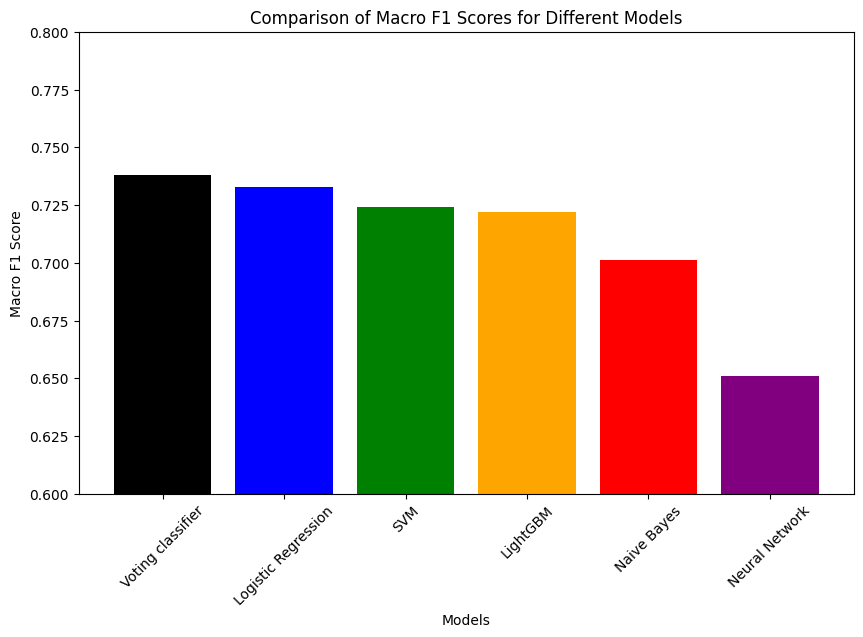

In [40]:
import matplotlib.pyplot as plt

models = ['Voting classifier', 'Logistic Regression', 'SVM', 'LightGBM', 'Naive Bayes', 'Neural Network']
f1_scores = [0.738, 0.733, 0.724, 0.722, 0.701, 0.651]

plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=['black', 'blue', 'green', 'orange', 'red', 'purple'])
plt.title('Comparison of Macro F1 Scores for Different Models')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylabel('Macro F1 Score')
plt.ylim(0.6, 0.8)
plt.show()

Macro F1 Score for Voting classifier: 0.7381726254965693


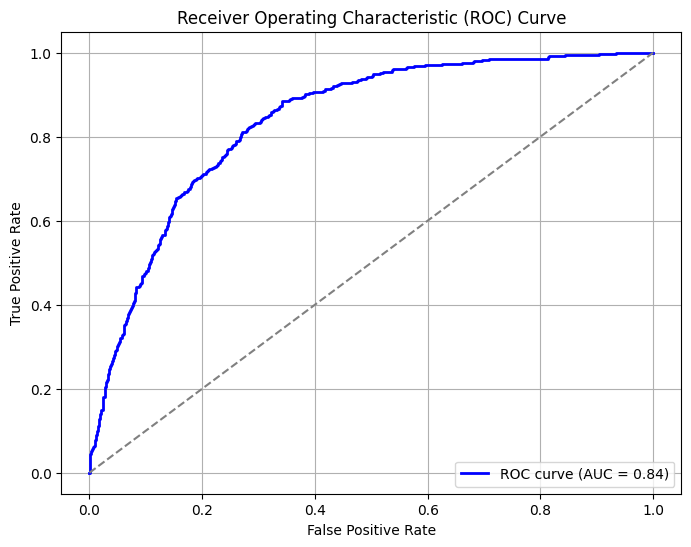

ROC AUC for Voting classifier: 0.84


In [61]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt


# Predict the probabilities on the validation set (for ROC curve)
y_prob_voting = voting_clf.predict_proba(X_val_selected)[:, 1]  # Probabilities for class 1

# Predict the class labels (for F1 score)
y_pred_voting = voting_clf.predict(X_val_selected)

# Calculate Macro F1 score
f1_lr = f1_score(y_val, y_pred_voting, average='macro')
print(f"Macro F1 Score for Voting classifier: {f1_lr}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_prob_voting)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no skill)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the AUC score
print(f"ROC AUC for Voting classifier: {roc_auc:.2f}")
